<a href="https://colab.research.google.com/github/ppen/DemoAPI/blob/master/DSE3_week5_Covid_19Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset จำนวนประชาการทั้งหมด จำนวนผู้ได้รับการติดเชื่อ covid -19 และจำนวนผู้ได้รับการตรวจ รวมถึงจำนวนการรักษา
จากเว็บไซต์ "https://corona.lmao.ninja/v2/countries?sort=country"

# Data Preprocessing 

In [ ]:
import requests 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from math import pi
from sklearn.cluster import KMeans 

ดึงข้อมูลผ่าน API 

In [ ]:


url = "https://corona.lmao.ninja/v3/covid-19/countries"

response = requests.get(url)
#response.json()
full_df = pd.DataFrame.from_dict(response.json())
full_df




#full_df

,updated,country,countryInfo,cases,todayCases,deaths,todayDeaths,recovered,todayRecovered,active,critical,casesPerOneMillion,deathsPerOneMillion,tests,testsPerOneMillion,population,continent,oneCasePerPeople,oneDeathPerPeople,oneTestPerPeople,undefined,activePerOneMillion,recoveredPerOneMillion,criticalPerOneMillion
0,1621333374930,Afghanistan,"{'_id': 4, 'iso2': 'AF', 'iso3': 'AFG', 'lat':...",64122,303,2762,11,55118,108,6242,1124,1616,70.0,434506,10947,39691394,Asia,619,14371,91,157.0,157.26,1388.66,28.32
1,1621333374898,Albania,"{'_id': 8, 'iso2': 'AL', 'iso3': 'ALB', 'lat':...",132032,0,2435,0,125419,0,4178,18,45924,847.0,677041,235489,2875041,Europe,22,1181,4,1453.0,1453.20,43623.38,6.26
2,1621333374905,Algeria,"{'_id': 12, 'iso2': 'DZ', 'iso3': 'DZA', 'lat'...",125485,0,3381,0,87476,0,34628,28,2817,76.0,230861,5183,44541312,Africa,355,13174,193,777.0,777.44,1963.93,0.63
3,1621333374975,Andorra,"{'_id': 20, 'iso2': 'AD', 'iso3': 'AND', 'lat'...",13555,0,127,0,13211,0,217,12,175190,1641.0,193595,2502100,77373,Europe,6,609,0,2805.0,2804.60,170744.32,155.09
4,1621333374948,Angola,"{'_id': 24, 'iso2': 'AO', 'iso3': 'AGO', 'lat'...",30787,0,677,0,25995,0,4115,22,912,20.0,527590,15631,33753337,Africa,1096,49857,64,122.0,121.91,770.15,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,1621333375056,Wallis and Futuna,"{'_id': 876, 'iso2': 'WF', 'iso3': 'WLF', 'lat...",445,0,7,0,436,0,2,1,40213,633.0,17264,1560094,11066,Australia/Oceania,25,1581,1,181.0,180.73,39399.96,90.37
218,1621333375072,Western Sahara,"{'_id': 732, 'iso2': 'EH', 'iso3': 'ESH', 'lat...",10,0,1,0,8,0,1,0,16,2.0,0,0,610112,Africa,61011,610112,0,2.0,1.64,13.11,0.00
219,1621333375007,Yemen,"{'_id': 887, 'iso2': 'YE', 'iso3': 'YEM', 'lat...",6568,0,1294,0,3042,0,2232,23,216,43.0,38810,1277,30397797,Asia,4628,23491,783,73.0,73.43,100.07,0.76
220,1621333374916,Zambia,"{'_id': 894, 'iso2': 'ZM', 'iso3': 'ZMB', 'lat...",92460,0,1261,0,90862,0,337,40,4910,67.0,1474620,78307,18831181,Africa,204,14934,13,18.0,17.90,4825.08,2.12


คัดเลือก Feature ที่จะนำมาจัดกลุ่ม

In [ ]:
feat_cols = ['casesPerOneMillion','deathsPerOneMillion','testsPerOneMillion','activePerOneMillion','recoveredPerOneMillion']

df = full_df[feat_cols]

df.head()

,casesPerOneMillion,deathsPerOneMillion,testsPerOneMillion,activePerOneMillion,recoveredPerOneMillion
0,1616,70.0,10947,157.26,1388.66
1,45924,847.0,235489,1453.20,43623.38
2,2817,76.0,5183,777.44,1963.93
3,175190,1641.0,2502100,2804.60,170744.32
4,912,20.0,15631,121.91,770.15


Feature ที่นำมาจัดกลุ่มได้แก่
1. casesPerOneMillion  = จำนวนผู้ติดเชื่อ covid / 1ล้านคน
2. deathsPerOneMillion = จำนวนผู้เสียชีวิตจาก covid-19 / 1ล้านคน
3. testsPerOneMillion = จำนวนผู้ได้รับการตรวจหา coivid-19 /1ล้านคน 
4. activePerOneMillion = จำนวนำผู้กำลังรักษา covid-19 /1ล้านคน
5. recoveredPerOneMillion = จำนวนผู้รักษาหายจาก covid-19  / 1ล้านคน

In [ ]:
df_norm = df.copy()
df_norm = (df_norm - df_norm.min())/ (df_norm.max()- df_norm.min())

df_norm

,casesPerOneMillion,deathsPerOneMillion,testsPerOneMillion,activePerOneMillion,recoveredPerOneMillion
0,0.009224,0.023049,0.001347,0.002570,0.008133
1,0.262138,0.278894,0.028973,0.023753,0.255489
2,0.016080,0.025025,0.000638,0.012708,0.011502
3,1.000000,0.540336,0.307843,0.045842,1.000000
4,0.005206,0.006585,0.001923,0.001993,0.004511
...,...,...,...,...,...
217,0.229539,0.208429,0.191945,0.002954,0.230754
218,0.000091,0.000659,0.000000,0.000027,0.000077
219,0.001233,0.014159,0.000157,0.001200,0.000586
220,0.028027,0.022061,0.009634,0.000293,0.028259


# หาจำนวน cluster ที่เหมาะสมที่สุดสำหรับ K-means Clustering ด้วย elbow method

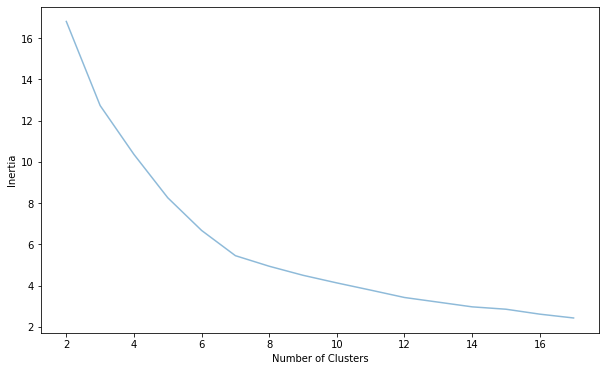

In [ ]:
#elbow method

min_range = 2
max_range = 18

inertia = []
k_list = range(min_range, max_range)

for k in k_list:
    km = KMeans(n_clusters = k, random_state= 0)
    km.fit(df_norm)
    score = km.inertia_
    inertia.append(score)


plt.figure(1 , figsize = (10 ,6))
# plt.plot(np.arange(min_range , max_range) , inertia , 'o')
plt.plot(np.arange(min_range , max_range) , inertia , '-' , alpha = 0.5)

plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()


In [ ]:
def calculate_wcss(data):
    wcss = []
    for n in range(min_range, max_range):
        kmeans = KMeans(n_clusters=n,random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    
    return wcss

from math import sqrt

def optimal_number_of_clusters(wcss):
    x1, y1 = min_range, wcss[0]
    x2, y2 = max_range, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2
    

# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(df_norm)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Optimal Number fo cluster =', n)

Optimal Number fo cluster = 5


# K-means Clustering 

In [ ]:
# K-mean clustering at K = 6

km = KMeans(n_clusters=6, random_state =0)
km.fit(df_norm)
cluster = km.predict(df_norm)
cluster_df = df.copy()
cluster_df['cluster'] = cluster

pd.set_option('display.float_format', '{:20,.2f}'.format)
avg_cluster_df = cluster_df.groupby(by='cluster').mean()
avg_cluster_df.reset_index(inplace=True)
avg_cluster_df

,cluster,casesPerOneMillion,deathsPerOneMillion,testsPerOneMillion,activePerOneMillion,recoveredPerOneMillion
0,0,"6,507.67",94.01,"227,292.25",828.70,"5,584.91"
1,1,"81,386.70","1,646.16","957,640.78","4,861.02","74,879.57"
2,2,"66,227.67",341.33,"1,079,851.67","41,145.26","24,741.15"
3,3,"43,805.57",438.00,"4,833,238.43","4,856.36","38,511.12"
4,4,"49,734.32",750.21,"558,242.32","2,990.05","45,994.04"
5,5,"152,750.80","2,471.60","2,858,188.20","1,576.99","148,702.40"


# DATA VISUALIZATION USING PI CHART

In [ ]:
from math import pi

def plot_radar_df(df, feat_cols, label_col, selected_label_list, split_chart=False, dpi=100, n_cols = 3, fig_h=8, fig_w=8):
    
    # min-max normalization
    for col in feat_cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    # select data:
    row_idx = df[label_col].isin(selected_label_list)
    data = df[row_idx]
    data = data[feat_cols].values

    # number of variable
    N = len(feat_cols)

    # angle of each axis in the plot
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # set color
    my_color = plt.cm.get_cmap("Set2", len(df.index))

    # set font size and subplot
    if not split_chart:
        ax = plt.subplot(111, polar=True )
        size = 10
    else:
        size = 5
        dpi = 1.5*dpi

    for i in range(len(data)):

        title = label_col +'_' +str(selected_label_list[i])

        # Initialise the spider plot
        if split_chart:
            n_rows = np.ceil(len(df)/n_cols)
            ax = plt.subplot(n_rows,n_cols,i+1, polar=True )

        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], feat_cols, color='grey', size=int(size*0.8))

        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([0.20, 0.4, 0.6, 0.8,  1], \
                   ["20%","40%","60%","80%","100%"], color="grey", size=size)
        plt.ylim(0,1)

        # Plot
        values = list(data[i,:])
        values += values[:1]
        ax.plot(angles, values, color=my_color(i), linewidth=2, linestyle='solid', label=title)
        ax.fill(angles, values, color=my_color(i), alpha=0.4)

        # Add a title or legend
        if split_chart:
            plt.title(title, size=11, color=my_color(i), y=1.2)
        else:
            plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

        # Adjust DPI
        fig = plt.gcf()
        fig.set_dpi(dpi)
        fig.set_figheight(fig_h)
        fig.set_figwidth(fig_w)

    plt.tight_layout()
    plt.show()

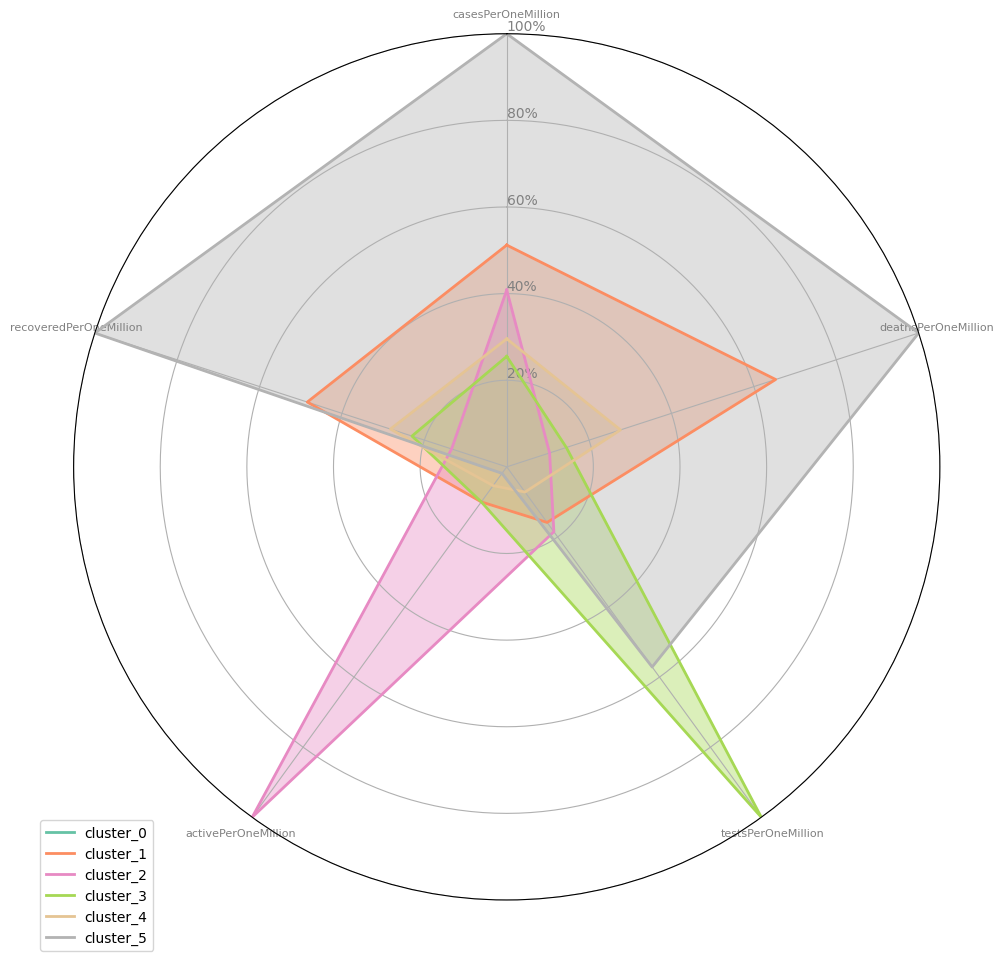

In [ ]:
feat_cols = ['casesPerOneMillion','deathsPerOneMillion','testsPerOneMillion','activePerOneMillion','recoveredPerOneMillion']

label_col = 'cluster'
selected_label_list = [i for i in range(6)]

plot_radar_df(avg_cluster_df, feat_cols, label_col, selected_label_list, split_chart=False, dpi=100, n_cols=3, fig_h=10, fig_w=10)

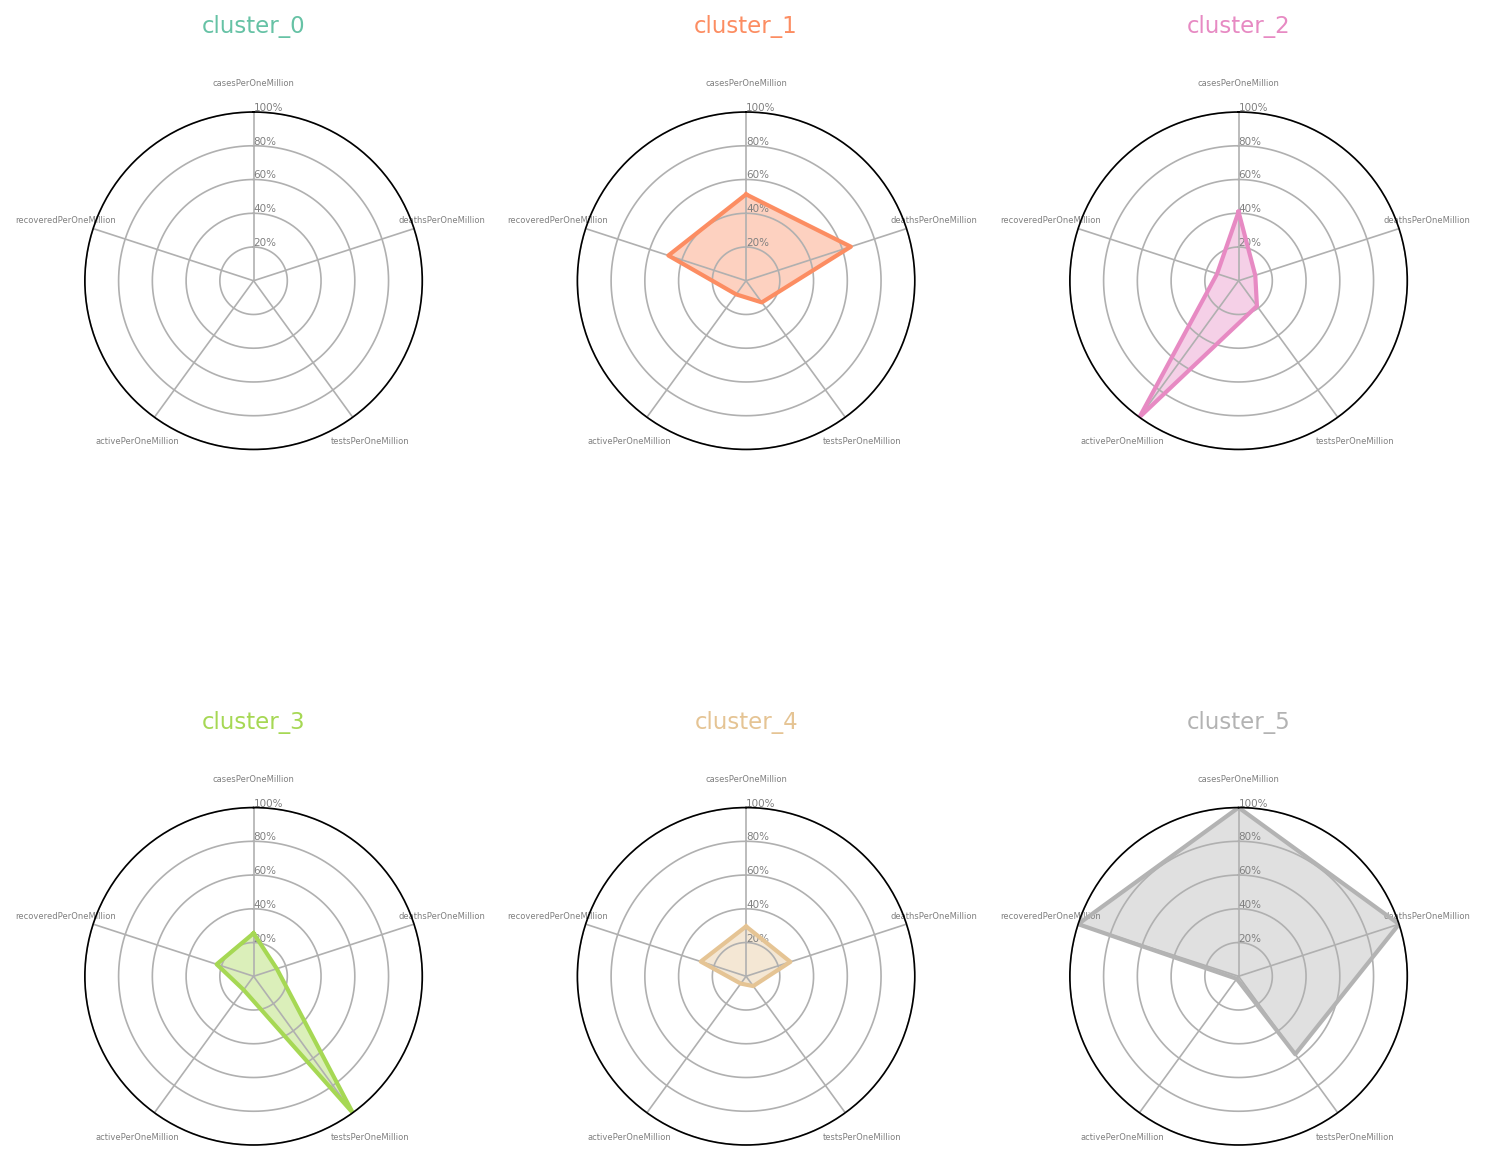

In [ ]:
plot_radar_df(avg_cluster_df, feat_cols, label_col, selected_label_list, split_chart=True, dpi=100, n_cols=3, fig_h=10, fig_w=10)



cluster ที่ 0 และ 1 
- อัตราผู้ติด covid-19 มีจำนวนน้อย  

Cluster ที่ 2
- อัตราผู้ติดเชื้อ,ผู้เสียชีวิต,รักษาหาย,ได้รับการตรวจ covid-19 จำนวนมาก

Cluster ที่ 3 
- อัตราผู้เสียชีวิตมากเมื่อเทียบกับจำนวนผู้ติด covid-19 และ ผู้ได้รับการตรวจหา covid-19 
- การสาธารณสุขอาจไม่ดี

Cluster ที่ 4 
- อัตราผู้อยู่ในกำลังรักษาจำนวนมาก

Cluster ที่ 5 
- อัตราผู้ได้รับการตรวจ covid-19 จำนวนมาก
- อัตราผู้ติดเชื้อ,เสียชีวิต,กำลังรักษา,รักษาหายแล้ว มีจำนวนน้อย 




# ประเทศไทยอยู่ cluster ใด 

In [ ]:
cluster_full_df = full_df.copy()
cluster_full_df['cluster'] = cluster

In [ ]:
cluster_full_df.head()

,updated,country,countryInfo,cases,todayCases,deaths,todayDeaths,recovered,todayRecovered,active,critical,casesPerOneMillion,deathsPerOneMillion,tests,testsPerOneMillion,population,continent,oneCasePerPeople,oneDeathPerPeople,oneTestPerPeople,undefined,activePerOneMillion,recoveredPerOneMillion,criticalPerOneMillion,cluster
0,1621333374930,Afghanistan,"{'_id': 4, 'iso2': 'AF', 'iso3': 'AFG', 'lat':...",64122,303,2762,11,55118,108,6242,1124,1616,70.00,434506,10947,39691394,Asia,619,14371,91,157.00,157.26,"1,388.66",28.32,0
1,1621333374898,Albania,"{'_id': 8, 'iso2': 'AL', 'iso3': 'ALB', 'lat':...",132032,0,2435,0,125419,0,4178,18,45924,847.00,677041,235489,2875041,Europe,22,1181,4,"1,453.00","1,453.20","43,623.38",6.26,4
2,1621333374905,Algeria,"{'_id': 12, 'iso2': 'DZ', 'iso3': 'DZA', 'lat'...",125485,0,3381,0,87476,0,34628,28,2817,76.00,230861,5183,44541312,Africa,355,13174,193,777.00,777.44,"1,963.93",0.63,0
3,1621333374975,Andorra,"{'_id': 20, 'iso2': 'AD', 'iso3': 'AND', 'lat'...",13555,0,127,0,13211,0,217,12,175190,"1,641.00",193595,2502100,77373,Europe,6,609,0,"2,805.00","2,804.60","170,744.32",155.09,5
4,1621333374948,Angola,"{'_id': 24, 'iso2': 'AO', 'iso3': 'AGO', 'lat'...",30787,0,677,0,25995,0,4115,22,912,20.00,527590,15631,33753337,Africa,1096,49857,64,122.00,121.91,770.15,0.65,0


In [ ]:
cluster_thai  = cluster_full_df.loc[cluster_full_df['country'] == "Thailand"]

cluster_thai = cluster_thai['cluster']

cluster_thai

200    0
Name: cluster, dtype: int32

In [ ]:
cluster_india  = cluster_full_df.loc[cluster_full_df['country'] == "China"]

cluster_india = cluster_india['cluster']

cluster_india

42    0
Name: cluster, dtype: int32

# รายชื่อประเทศใน Cluster ต่างๆ

cluster 0

In [ ]:

cluster_full_df.loc[cluster_full_df.cluster==0].country.tolist()

['Afghanistan',
 'Algeria',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Australia',
 'Bangladesh',
 'Barbados',
 'Benin',
 'Bhutan',
 'Botswana',
 'British Virgin Islands',
 'Brunei',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'China',
 'Comoros',
 'Congo',
 'Cuba',
 "Côte d'Ivoire",
 'DRC',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Ethiopia',
 'Falkland Islands (Malvinas)',
 'Fiji',
 'Finland',
 'Gabon',
 'Gambia',
 'Ghana',
 'Greenland',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Holy See (Vatican City State)',
 'Honduras',
 'Hong Kong',
 'Iceland',
 'India',
 'Indonesia',
 'Iraq',
 'Isle of Man',
 'Jamaica',
 'Japan',
 'Kazakhstan',
 'Kenya',
 'Kyrgyzstan',
 "Lao People's Democratic Republic",
 'Lesotho',
 'Liberia',
 'Libyan Arab Jamahiriya',
 'MS Zaandam',
 'Macao',
 'Madagascar',
 '

cluster 1

In [ ]:
cluster_full_df.loc[cluster_full_df.cluster==1].country.tolist()

['Argentina',
 'Armenia',
 'Aruba',
 'Bahrain',
 'Belgium',
 'Bosnia',
 'Brazil',
 'Bulgaria',
 'Chile',
 'Colombia',
 'Croatia',
 'Estonia',
 'France',
 'Georgia',
 'Hungary',
 'Israel',
 'Italy',
 'Latvia',
 'Lebanon',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Macedonia',
 'Moldova',
 'Netherlands',
 'Panama',
 'Peru',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'UK',
 'USA']

cluster 2

In [ ]:
cluster_full_df.loc[cluster_full_df.cluster==2].country.tolist()

['French Guiana',
 'Guadeloupe',
 'Maldives',
 'Martinique',
 'Mayotte',
 'St. Barth']

cluster 3

In [ ]:
cluster_full_df.loc[cluster_full_df.cluster==3].country.tolist()

['Austria',
 'Bermuda',
 'Channel Islands',
 'Cyprus',
 'Denmark',
 'Faroe Islands',
 'UAE']

cluster 4

In [ ]:
cluster_full_df.loc[cluster_full_df.cluster==4].country.tolist()

['Albania',
 'Azerbaijan',
 'Bahamas',
 'Belarus',
 'Belize',
 'Bolivia',
 'Cabo Verde',
 'Canada',
 'Caribbean Netherlands',
 'Costa Rica',
 'Curaçao',
 'Ecuador',
 'French Polynesia',
 'Germany',
 'Greece',
 'Iran',
 'Ireland',
 'Jordan',
 'Kuwait',
 'Malta',
 'Mexico',
 'Monaco',
 'Oman',
 'Palestine',
 'Paraguay',
 'Qatar',
 'Russia',
 'Saint Martin',
 'Serbia',
 'Seychelles',
 'Sint Maarten',
 'South Africa',
 'Tunisia',
 'Turkey',
 'Turks and Caicos Islands',
 'Ukraine',
 'Uruguay',
 'Wallis and Futuna']

cluster 5

In [ ]:
cluster_full_df.loc[cluster_full_df.cluster==5].country.tolist()

['Andorra', 'Czechia', 'Gibraltar', 'Montenegro', 'San Marino']